# 1 Introducción

El objetivo de este notebook es la implementación de un modelo de generación de lenguaje utilizando un dataset con tweets publicados por Obama. Tras procesar y analizar los tweets se creará un generador de tweets que pretenderá simular la redacción de Obama. El dataset analizado se ha obtenido de https://www.kaggle.com/speckledpingu/RawTwitterFeeds

El estudio que se va a realizar está dividio en dos partes:

1. En la primera parte se generarán cuatro modelos que analizar el texto de los tweets sin realizar ninguna tranformación ni eliminación de ningún carácter.
2. En la segunda parte se generarán cuatro modelos, con características similares a los de punto anterior, pero que procesarán un texto previamente tratado, en el que los caracteres estarán en minúsculas, se eliminarán menciones a usuarios, hashtags, enlaces, se procesarán tags de html, etc.

El texto que se procesará será el resultado de la concatenación de los textos de todos los tweets. La longitud de este texto es superior a los 800.000 caracters. Por razón de rendimiento computacional, para hacer las pruebas vamos a procesar únicamente los primeros 50.000 caracteres.

# 2 Librería necesarias



In [ ]:
import numpy as np
import pandas as pd
import random
import re
from html.parser import HTMLParser
from copy import deepcopy

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

# 3 Carga de datos
En este epígrafe se va a realizar la carga de datos de los tweets de Obama y crear una variable de texto con todos ellos concatenados. El texto resultado es el que se procesará para obtener diferentes modelos que generen tweets simulando ser Obama.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/BarackObama.csv')

In [ ]:
df.head()

Unnamed: 0  ...       author
0           0  ...  BarackObama
1           1  ...  BarackObama
2           2  ...  BarackObama
3           3  ...  BarackObama
4           4  ...  BarackObama

[5 rows x 7 columns]

In [ ]:
df.shape

(6896, 7)

In [ ]:
df.isna().sum()

Unnamed: 0    0
date          0
id            0
link          0
retweet       0
text          0
author        0
dtype: int64

In [ ]:
# No quedamos sólo con el texto de los tweets
tweets_df = df['text']

In [ ]:
tweets_df.head()

0    Denying climate change is dangerous. Join @OFA...
1    The American Bar Association gave Judge Garlan...
2    We need a fully functional Supreme Court. Edit...
3    Cynics, take note: When we #ActOnClimate, we b...
4    "That’s how we will overcome the challenges we...
Name: text, dtype: object

In [ ]:
tweets_df.shape

(6896,)

In [ ]:
# Longotud media de los tweets
np.mean(tweets_df.str.len())

113.48027842227378

In [ ]:
# Máxima longitud de  los tweets
np.max(tweets_df.str.len())

207

In [ ]:
# Mínima longitud de los tweets
np.min(tweets_df.str.len())

8

In [ ]:
# Número de tweets con más de 150 caracteres
len(tweets_df[tweets_df.str.len()> 150])

15

In [ ]:
# Comprobarmos que no hay ningún tweets con tres saltos de línea seguidos
len(tweets_df[tweets_df.str.contains('\n\n\n')])

0

In [ ]:
# Concatenamos los textos de los tweets y tilizamos como carácter de separación tres saltos de línea
text = tweets_df.str.cat(sep='\n\n\n')

In [ ]:
print('Longitud del corpus {}'.format(len(text)))

Longitud del corpus 803245


In [ ]:
# Debido a problemas de rendimiento computacional, vamos a reducir el tamaño del corpus
# Evidentemente, cuanto mayor sea el corpus, mejor, pero en nuestro caso no es posible
short_text = text[0:50000]

In [ ]:
short_text

'Denying climate change is dangerous. Join @OFA supporters in standing up for bold action now: http://ofa.bo/2dZNTRx\xa0 #ActOnClimate\n\n\nThe American Bar Association gave Judge Garland its highest rating. Senate leaders: #DoYourJob and fill the #SCOTUS vacancy.pic.twitter.com/4yseqnOBX4\n\n\nWe need a fully functional Supreme Court. Editorial boards across the country agree: http://ofa.bo/2dCG7KU\xa0 #DoYourJob\n\n\nCynics, take note: When we #ActOnClimate, we build a stronger future.pic.twitter.com/wHHMdo2ro6\n\n\n"That’s how we will overcome the challenges we face: by unleashing the power of all of us for all of us." Read more:http://ofa.bo/2dNlZZy\xa0\n\n\nCheck out the most recent editorial boards calling on Senate leaders to vote on Judge Garland: http://ofa.bo/2dNKl4h\xa0 #DoYourJob\n\n\nSenate leaders\' political games are handicapping the Supreme Court—and judgeships across the country. http://ofa.bo/2dVVHno\xa0 #DoYourJob\n\n\nSupport the bold steps we\'re taking against cl

In [ ]:
short_text.rindex('\n\n\n')

49872

In [ ]:
short_text = short_text[0:49872]

In [ ]:
# Función para transformar y filtrar caracteres especiales de los tweets
html_parser = HTMLParser()
def filter_characters(text):
  filtered_text = html_parser.unescape(text) # aplicar tranformaciones html
  filtered_text = re.sub('@[A-Za-z0-9_-]+', '', filtered_text) # quitar usernames
  filtered_text = re.sub('([#＃]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)', '', filtered_text) # quitar hashtag (se elimina hasta la segunda palabra que empieza por mayúscula)
  filtered_text = re.sub('([--:\w?@%&+~#=]*\.[a-z]{2,4}\/{0,2})((?:[?&](?:\w+)=(?:\w+))+|[--:\w?@%&+~#=]+)?', '', filtered_text) # quitar enlaces internos, por ejemplo, a imágenes
  filtered_text = re.sub('\\xa0', '', filtered_text) # quitar marcas de fin de enlaces

  return filtered_text.lower()

In [ ]:
filtered_short_text = filter_characters(short_text)
filtered_short_text

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  after removing the cwd from sys.path.


'denying climate change is dangerous. join  supporters in standing up for bold action now:  onclimate\n\n\nthe american bar association gave judge garland its highest rating. senate leaders: yourjob and fill the  \n\n\nwe need a fully functional supreme court. editorial boards across the country agree:  yourjob\n\n\ncynics, take note: when we onclimate, we build a stronger \n\n\n"that’s how we will overcome the challenges we face: by unleashing the power of all of us for all of us." read \n\n\ncheck out the most recent editorial boards calling on senate leaders to vote on judge garland:  yourjob\n\n\nsenate leaders\' political games are handicapping the supreme court—and judgeships across the country.  yourjob\n\n\nsupport the bold steps we\'re taking against climate change. say you\'re ready to onclimate: \n\n\nlast week, more than 190 countries reached a landmark deal to reduce carbon pollution from aviation.  onclimate\n\n\nlet\'s leave our children and grandchildren a planet that\'

# 4 Funciones principales


## 4.1 Función de preprocesado



In [ ]:
def preprocesado(text, seq_length):
  characters = sorted(list(set(text)))
  n_to_char = {n:char for n, char in enumerate(characters)}
  char_to_n = {char:n for n, char in enumerate(characters)}

  X = []
  Y = []
  length = len(text)
  for i in range(0, length-seq_length, 1):
      sequence = text[i:i + seq_length]
      label =text[i + seq_length]
      X.append([char_to_n[char] for char in sequence])
      Y.append(char_to_n[label])
  X_modified = np.reshape(X, (len(X), seq_length, 1))
  X_modified = X_modified / float(len(characters))
  Y_modified = np_utils.to_categorical(Y)

  return X, X_modified, Y_modified, len(characters), n_to_char, char_to_n

## 4.2 Ejecución de modelos
En este epígrafe se crea una función que crea cuatro modelos deep learning, del más simple al más complejo. Se empieza con dos modelos con solos dos capas LSTM separados por Dropout con un 20% de eliminación aleatoria de neuronas, se sigue con otro modelo en el que se añade un tercer par de capas LSTM con Dropout. Por último, se crea un modelo similar al primero y segundo, pero con muchas más neuronas. Todos los modelos tienen una capa final Densa con función de activación softmax. Todos los modelos cargan una serie de pesos de modelos preentrenados.

El número de neuronas que se han establecido es bajo debido, como se ha comentado antes, a tiempos de computación. En el modelo más simple, el primero, inicialmente con 400 neuronas y todo el corpus (más de 800.000 caracteres), los tiempos de ejecución de una época en los entrenamientos rondan las 11 horas. Para reducir estos tiempos se reduce el corpus, las neuronas y  número de capas. Por eso, por ejemplo, el primer modelo mencionado pasa a tener solo 100 neuronas y también se ha reducido el número de épocas.

En esta función se cargan una serie de pesos de modelo ya preentrenados, que se realizan más adelante en el notebook. Esta función está pensada para ser ejecutada varias veces con distintos textos y no tener que reentrenar de nuevo.

In [ ]:
def gen_models(X_modified, Y_modified, model_1_path, model_2_path, model_3_path, model_4_path):
  # Model 1
  model_1 = Sequential()
  model_1.add(LSTM(100, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
  model_1.add(Dropout(0.2))
  model_1.add(LSTM(100))
  model_1.add(Dropout(0.2))
  model_1.add(Dense(Y_modified.shape[1], activation='softmax'))
  model_1.compile(loss='categorical_crossentropy', optimizer='adam')
  model_1.load_weights(model_1_path)

  # Model 2
  model_2 = Sequential()
  model_2.add(LSTM(200, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
  model_2.add(Dropout(0.2))
  model_2.add(LSTM(200))
  model_2.add(Dropout(0.2))
  model_2.add(Dense(Y_modified.shape[1], activation='softmax'))
  model_2.compile(loss='categorical_crossentropy', optimizer='adam')
  model_2.load_weights(model_2_path)

  # Model 3 - Se añade una capa más de LSTM y de Dropout
  model_3 = Sequential()
  model_3.add(LSTM(100, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
  model_3.add(Dropout(0.2))
  model_3.add(LSTM(100, return_sequences=True))
  model_3.add(Dropout(0.2))
  model_3.add(LSTM(100))
  model_3.add(Dropout(0.2))
  model_3.add(Dense(Y_modified.shape[1], activation='softmax'))
  model_3.compile(loss='categorical_crossentropy', optimizer='adam')
  model_3.load_weights(model_3_path)

  # Model 4
  model_4 = Sequential()
  model_4.add(LSTM(300, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
  model_4.add(Dropout(0.2))
  model_4.add(LSTM(300))
  model_4.add(Dropout(0.2))
  model_4.add(Dense(Y_modified.shape[1], activation='softmax'))
  model_4.compile(loss='categorical_crossentropy', optimizer='adam')
  model_4.load_weights(model_4_path)
  
  return model_1, model_2, model_3, model_4

## 4.3 Función que genera los tweets

Función que debe ser utilizada para generar tweets con distintos modelos.

- model: modelo que se quiera evaluar
- string_id: texto semilla a partir del cual se genera el tweet. El texto se recibe con el identificador numérico de cada carácter.
- n_to_char: mapa de números a caracteres con que se generó el modelo.
- tweet_len: longitud que se quiere de los tweets generados



In [ ]:
def generate_tweet(model, string_id, n_to_char, max_characters, tweet_len):
    string_mapped = deepcopy(string_id)
    full_string = [n_to_char[value] for value in string_mapped]
    
    # Generating characters
    for i in range(tweet_len+1):
        x = np.reshape(string_mapped,(1,len(string_mapped), 1))
        x = x / float(max_characters)

        pred_index = np.argmax(model.predict(x, verbose=0))
        # la siguiente sentencia no sería necesaria
        # seq = [n_to_char[value] for value in string_mapped]
        full_string.append(n_to_char[pred_index])

        string_mapped.append(pred_index)
        string_mapped = string_mapped[1:len(string_mapped)]
        
    tweet = ""
    for char in full_string:
        tweet = tweet + char
    return tweet

## 4.4 Función que convierte cadenas de números a cadenas de texto

Dada una cadena de números que representa a un texto, develeve en texto en formato carácter.

- string_id: cadena de números que representa una texto
- n_to_char: array que mapea números con caracteres




In [ ]:
def tranform_number_to_text(string_id, n_to_char):
  t = ''
  for ch in string_id:
      t += n_to_char.get(ch)
  return t

# 5 Creación de modelos

En esta sección se van a crear distintos modelos, probando distintas combinaciones de capas, número de neuronas y caracteres admitidos en el corpus. El objetivo de esta sección es obtener un pesos que sean resultado del preentrenamiento y puedan ser utilizados más adelante las veces que se quiera. De hecho, los pesos obtenido se cargan en la función de ejecución de modelos presentada en la sección anterior.

Simplemente por obtener información más gráfica, en algunos de los modelos, no en todos, presentaremos gráfica de accuracy y/o loss. 

## 5.1 Tweets sin procesar

En este epígrafe vamos a probar los modelos sin modificar ni filtrar nada en los textos de los tweets

### 5.1.1 Preprocesado de corpus

In [ ]:
# Ponemos 150 de longitud por ser la longitud máxima de los tweets durante mucho
# tiempo fue de 140 y debido a que la longitud media de los tweets son de 113.4
# y hay muy pocos tweets de más de 150 caracteres
X, X_modified, Y_modified, max_characters, n_to_char, char_to_n = preprocesado(short_text, 150)

In [ ]:
X_modified.shape

(49722, 150, 1)

In [ ]:
Y_modified.shape

(49722, 88)

In [ ]:
max_characters

88

### 5.1.2 Creación modelo 1


In [ ]:
model_1 = Sequential()
model_1.add(LSTM(100, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_1.add(Dropout(0.2))
model_1.add(LSTM(100))
model_1.add(Dropout(0.2))
model_1.add(Dense(Y_modified.shape[1], activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 88)                8888      
Total params: 130,088
Trainable params: 130,088
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamiento
history_1 = model_1.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Train on 47235 samples, validate on 2487 samples
Epoch 1/10
47235/47235 [==============================] - 335s 7ms/step - loss: 3.5066 - accuracy: 0.1095 - val_loss: 3.5514 - val_accuracy: 0.1142
Epoch 2/10
47235/47235 [==============================] - 339s 7ms/step - loss: 3.3740 - accuracy: 0.1377 - val_loss: 3.3592 - val_accuracy: 0.1552
Epoch 3/10
47235/47235 [==============================] - 332s 7ms/step - loss: 3.2348 - accuracy: 0.1636 - val_loss: 3.2519 - val_accuracy: 0.1713
Epoch 4/10
47235/47235 [==============================] - 337s 7ms/step - loss: 3.0825 - accuracy: 0.1906 - val_loss: 3.1343 - val_accuracy: 0.1942
Epoch 5/10
47235/47235 [==============================] - 336s 7ms/step - loss: 2.9312 - accuracy: 0.2263 - val_loss: 2.9878 - val_accuracy: 0.2244
Epoch 6/10
47235/47235 [==============================] - 334s 7ms/step - loss: 2.8186 - accuracy: 0.2530 - val_loss: 2.9036 - val_accuracy: 0.2433
Epoch 7/10
47235/47235 [==============================] - 332s 

In [ ]:
model_1.save_weights('/content/drive/My Drive/model_1_sin_filtro.h5')

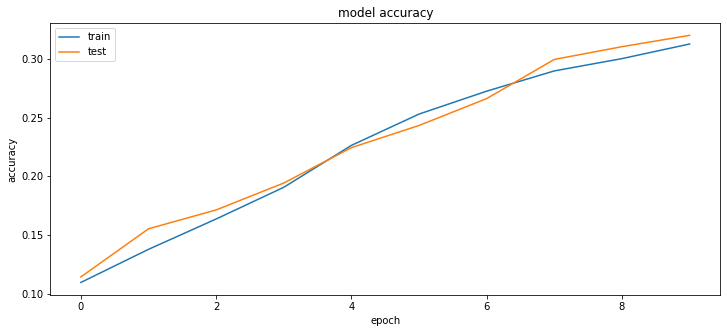

In [ ]:
# Model accuracy
plt.plot(history_1['accuracy'])
plt.plot(history_1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

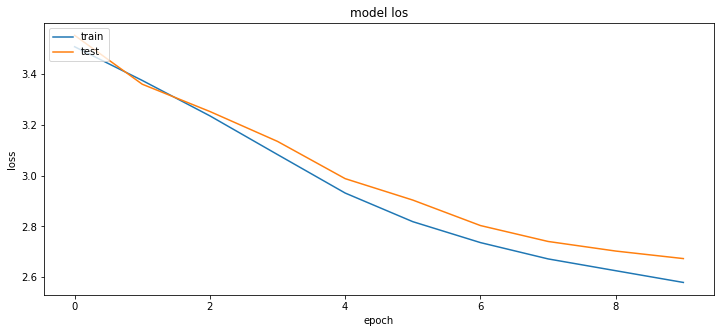

In [ ]:
plt.plot(history_1['loss'])
plt.plot(history_1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

### 5.1.3 Creación modelo 2

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(200, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(200))
model_2.add(Dropout(0.2))
model_2.add(Dense(Y_modified.shape[1], activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150, 200)          161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 88)                17688     
Total params: 500,088
Trainable params: 500,088
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamiento
history_2 = model_2.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=5, shuffle=True).history

Train on 47235 samples, validate on 2487 samples
Epoch 1/5
47235/47235 [==============================] - 854s 18ms/step - loss: 3.5424 - accuracy: 0.1039 - val_loss: 3.5739 - val_accuracy: 0.1146
Epoch 2/5
47235/47235 [==============================] - 849s 18ms/step - loss: 3.3765 - accuracy: 0.1375 - val_loss: 3.3627 - val_accuracy: 0.1472
Epoch 3/5
47235/47235 [==============================] - 860s 18ms/step - loss: 3.1369 - accuracy: 0.1812 - val_loss: 3.1246 - val_accuracy: 0.1854
Epoch 4/5
47235/47235 [==============================] - 845s 18ms/step - loss: 2.8619 - accuracy: 0.2420 - val_loss: 2.8449 - val_accuracy: 0.2593
Epoch 5/5
47235/47235 [==============================] - 848s 18ms/step - loss: 2.6702 - accuracy: 0.2908 - val_loss: 2.9925 - val_accuracy: 0.2425


In [ ]:
model_2.save_weights('/content/drive/My Drive/model_2_sin_filtro.h5')

### 5.1.4 Creación modelo 3

In [ ]:
model_3 = Sequential()
model_3.add(LSTM(100, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(100, return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(100))
model_3.add(Dropout(0.2))
model_3.add(Dense(Y_modified.shape[1], activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 150, 100)          40800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 150, 100)          80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 88)               

In [ ]:
history_3 = model_3.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Train on 47235 samples, validate on 2487 samples
Epoch 1/10
47235/47235 [==============================] - 537s 11ms/step - loss: 3.5641 - val_loss: 3.6005
Epoch 2/10
47235/47235 [==============================] - 530s 11ms/step - loss: 3.5148 - val_loss: 3.5885
Epoch 3/10
47235/47235 [==============================] - 529s 11ms/step - loss: 3.4359 - val_loss: 3.3930
Epoch 4/10
47235/47235 [==============================] - 530s 11ms/step - loss: 3.2470 - val_loss: 3.2600
Epoch 5/10
47235/47235 [==============================] - 530s 11ms/step - loss: 3.0854 - val_loss: 3.0904
Epoch 6/10
47235/47235 [==============================] - 531s 11ms/step - loss: 2.9191 - val_loss: 2.9214
Epoch 7/10
47235/47235 [==============================] - 536s 11ms/step - loss: 2.7876 - val_loss: 2.8207
Epoch 8/10
47235/47235 [==============================] - 535s 11ms/step - loss: 2.6924 - val_loss: 2.7491
Epoch 9/10
47235/47235 [==============================] - 532s 11ms/step - loss: 2.6223 - val_l

In [ ]:
model_3.save_weights('/content/drive/My Drive/model_3_sin_filtro.h5')

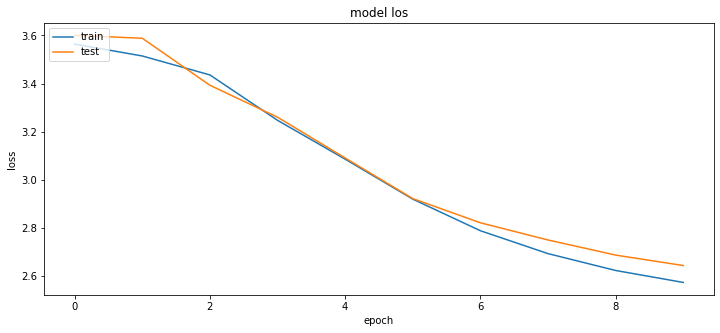

In [ ]:
plt.plot(history_3['loss'])
plt.plot(history_3['val_loss'])
plt.title('model los')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

### 5.1.5 Creación modelo 4

In [ ]:
# Model 4
model_4 = Sequential()
model_4.add(LSTM(300, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_4.add(Dropout(0.2))
model_4.add(LSTM(300))
model_4.add(Dropout(0.2))
model_4.add(Dense(Y_modified.shape[1], activation='softmax'))
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_4.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150, 300)          362400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 88)                26488     
Total params: 1,110,088
Trainable params: 1,110,088
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_4 = model_4.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=6, shuffle=True).history

Train on 47235 samples, validate on 2487 samples
Epoch 1/6
47235/47235 [==============================] - 1575s 33ms/step - loss: 3.5479 - accuracy: 0.1050 - val_loss: 3.5520 - val_accuracy: 0.1134
Epoch 2/6
47235/47235 [==============================] - 1617s 34ms/step - loss: 3.3806 - accuracy: 0.1351 - val_loss: 3.3865 - val_accuracy: 0.1508
Epoch 3/6
47235/47235 [==============================] - 1616s 34ms/step - loss: 3.1720 - accuracy: 0.1725 - val_loss: 3.1703 - val_accuracy: 0.1705
Epoch 4/6
47235/47235 [==============================] - 1588s 34ms/step - loss: 2.9004 - accuracy: 0.2319 - val_loss: 2.9287 - val_accuracy: 0.2425
Epoch 5/6
47235/47235 [==============================] - 1555s 33ms/step - loss: 2.7164 - accuracy: 0.2778 - val_loss: 2.7452 - val_accuracy: 0.2843
Epoch 6/6
47235/47235 [==============================] - 1557s 33ms/step - loss: 2.5938 - accuracy: 0.3068 - val_loss: 2.6501 - val_accuracy: 0.3060


In [ ]:
model_4.save_weights('/content/drive/My Drive/model_4_sin_filtro.h5')

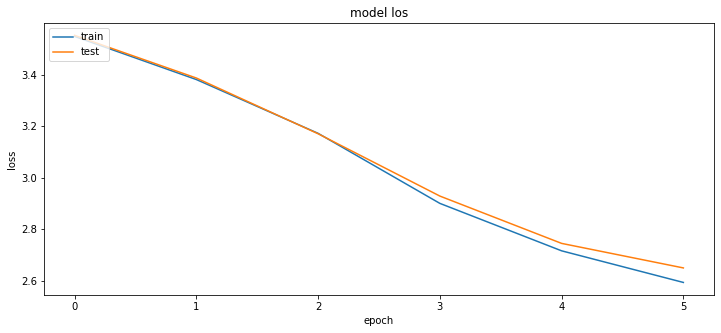

In [ ]:
plt.plot(history_4['loss'])
plt.plot(history_4['val_loss'])
plt.title('model los')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## 5.2 Tweets filtrados

En este epígrafe vamos a probar los modelos conviertiendo y filtrando caracteres de los textos de los tweets

### 5.2.1 Preprocesado de corpus

In [ ]:
# Ponemos 150 de longitud por ser la longitud máxima de los tweets durante mucho
# tiempo fue de 140 y debido a que la longitud media de los tweets son de 113.4
# y hay muy pocos tweets de más de 150 caracteres
X, X_modified, Y_modified, max_filtered_characters, n_to_char, char_to_n = preprocesado(filtered_short_text, 150)

In [ ]:
X_modified.shape

(35766, 150, 1)

In [ ]:
Y_modified.shape

(35766, 60)

In [ ]:
max_filtered_characters

60

### 5.2.2 Creación de modelo 5


In [ ]:
model_5 = Sequential()
model_5.add(LSTM(100, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_5.add(Dropout(0.2))
model_5.add(LSTM(100))
model_5.add(Dropout(0.2))
model_5.add(Dense(Y_modified.shape[1], activation='softmax'))
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150, 100)          40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
Total params: 127,260
Trainable params: 127,260
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamiento
history_5 = model_5.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Train on 33977 samples, validate on 1789 samples
Epoch 1/10
33977/33977 [==============================] - 233s 7ms/step - loss: 3.1430 - accuracy: 0.1449 - val_loss: 3.1029 - val_accuracy: 0.1593
Epoch 2/10
33977/33977 [==============================] - 233s 7ms/step - loss: 3.0659 - accuracy: 0.1559 - val_loss: 3.0462 - val_accuracy: 0.1738
Epoch 3/10
33977/33977 [==============================] - 232s 7ms/step - loss: 2.9531 - accuracy: 0.1912 - val_loss: 2.9339 - val_accuracy: 0.2085
Epoch 4/10
33977/33977 [==============================] - 230s 7ms/step - loss: 2.8687 - accuracy: 0.2141 - val_loss: 2.8882 - val_accuracy: 0.2091
Epoch 5/10
33977/33977 [==============================] - 230s 7ms/step - loss: 2.8371 - accuracy: 0.2162 - val_loss: 2.8646 - val_accuracy: 0.2124
Epoch 6/10
33977/33977 [==============================] - 229s 7ms/step - loss: 2.8090 - accuracy: 0.2191 - val_loss: 2.8324 - val_accuracy: 0.2119
Epoch 7/10
33977/33977 [==============================] - 230s 

In [ ]:
model_5.save_weights('/content/drive/My Drive/model_5_con_filtro.h5')

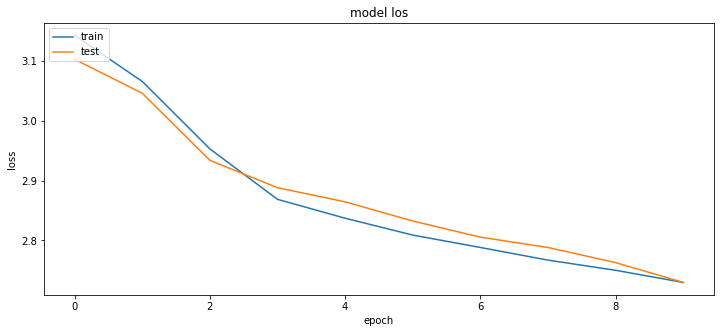

In [ ]:
plt.plot(history_5['loss'])
plt.plot(history_5['val_loss'])
plt.title('model los')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

### 5.2.3 Creación de modelo 6

In [ ]:
model_6 = Sequential()
model_6.add(LSTM(200, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_6.add(Dropout(0.2))
model_6.add(LSTM(200))
model_6.add(Dropout(0.2))
model_6.add(Dense(Y_modified.shape[1], activation='softmax'))
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150, 200)          161600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                12060     
Total params: 494,460
Trainable params: 494,460
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_6 = model_6.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=5, shuffle=True).history

Train on 33977 samples, validate on 1789 samples
Epoch 1/5
33977/33977 [==============================] - 585s 17ms/step - loss: 3.1127 - accuracy: 0.1516 - val_loss: 3.0742 - val_accuracy: 0.1744
Epoch 2/5
33977/33977 [==============================] - 582s 17ms/step - loss: 2.9443 - accuracy: 0.1930 - val_loss: 2.9327 - val_accuracy: 0.1979
Epoch 3/5
33977/33977 [==============================] - 582s 17ms/step - loss: 2.8450 - accuracy: 0.2153 - val_loss: 2.8496 - val_accuracy: 0.2107
Epoch 4/5
33977/33977 [==============================] - 579s 17ms/step - loss: 2.7892 - accuracy: 0.2199 - val_loss: 2.7946 - val_accuracy: 0.2174
Epoch 5/5
33977/33977 [==============================] - 581s 17ms/step - loss: 2.7471 - accuracy: 0.2248 - val_loss: 2.7424 - val_accuracy: 0.2376


In [ ]:
model_6.save_weights('/content/drive/My Drive/model_6_con_filtro.h5')

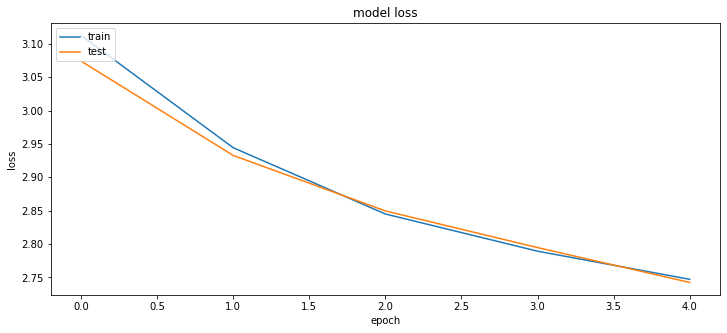

In [ ]:
plt.plot(history_6['loss'])
plt.plot(history_6['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

### 5.2.4 Creación modelo 7

In [ ]:
model_7 = Sequential()
model_7.add(LSTM(100, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_7.add(Dropout(0.2))
model_7.add(LSTM(100, return_sequences=True))
model_7.add(Dropout(0.2))
model_7.add(LSTM(100))
model_7.add(Dropout(0.2))
model_7.add(Dense(Y_modified.shape[1], activation='softmax'))
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 100)          80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)               

In [ ]:
history_7 = model_7.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Train on 33977 samples, validate on 1789 samples
Epoch 1/10
33977/33977 [==============================] - 356s 10ms/step - loss: 3.1378 - val_loss: 3.1161
Epoch 2/10
33977/33977 [==============================] - 351s 10ms/step - loss: 3.0786 - val_loss: 3.1010
Epoch 3/10
33977/33977 [==============================] - 350s 10ms/step - loss: 3.0707 - val_loss: 3.1040
Epoch 4/10
33977/33977 [==============================] - 355s 10ms/step - loss: 2.9970 - val_loss: 2.9499
Epoch 5/10
33977/33977 [==============================] - 351s 10ms/step - loss: 2.8611 - val_loss: 2.8800
Epoch 6/10
33977/33977 [==============================] - 350s 10ms/step - loss: 2.8222 - val_loss: 2.8367
Epoch 7/10
33977/33977 [==============================] - 349s 10ms/step - loss: 2.7954 - val_loss: 2.7999
Epoch 8/10
33977/33977 [==============================] - 352s 10ms/step - loss: 2.7655 - val_loss: 2.7659
Epoch 9/10
33977/33977 [==============================] - 360s 11ms/step - loss: 2.7407 - val_l

In [ ]:
model_7.save_weights('/content/drive/My Drive/model_7_con_filtro.h5')

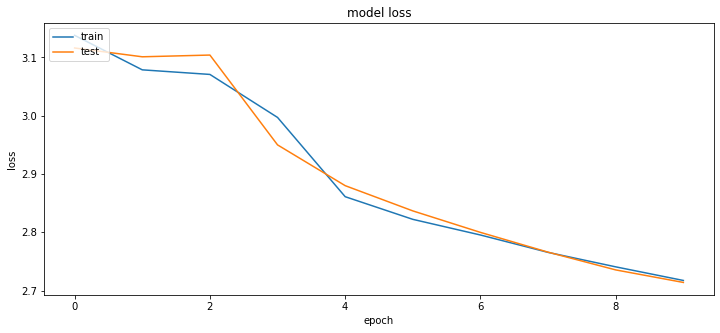

In [ ]:
plt.plot(history_7['loss'])
plt.plot(history_7['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

### 5.2.4 Creación modelo 8


In [ ]:
# Model 8
model_8 = Sequential()
model_8.add(LSTM(300, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_8.add(Dropout(0.2))
model_8.add(LSTM(300))
model_8.add(Dropout(0.2))
model_8.add(Dense(Y_modified.shape[1], activation='softmax'))
model_8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_8.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150, 300)          362400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                18060     
Total params: 1,101,660
Trainable params: 1,101,660
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_8 = model_8.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=6, shuffle=True).history

Train on 33977 samples, validate on 1789 samples
Epoch 1/6
33977/33977 [==============================] - 1039s 31ms/step - loss: 3.0907 - accuracy: 0.1545 - val_loss: 3.0228 - val_accuracy: 0.1822
Epoch 2/6
33977/33977 [==============================] - 1032s 30ms/step - loss: 2.9038 - accuracy: 0.2026 - val_loss: 2.8905 - val_accuracy: 0.2029
Epoch 3/6
33977/33977 [==============================] - 1033s 30ms/step - loss: 2.8121 - accuracy: 0.2179 - val_loss: 2.8057 - val_accuracy: 0.2091
Epoch 4/6
33977/33977 [==============================] - 1056s 31ms/step - loss: 2.7544 - accuracy: 0.2264 - val_loss: 2.7596 - val_accuracy: 0.2230
Epoch 5/6
33977/33977 [==============================] - 1055s 31ms/step - loss: 2.7003 - accuracy: 0.2374 - val_loss: 2.6873 - val_accuracy: 0.2448
Epoch 6/6
33977/33977 [==============================] - 1055s 31ms/step - loss: 2.6365 - accuracy: 0.2560 - val_loss: 2.5889 - val_accuracy: 0.2834


In [ ]:
model_8.save_weights('/content/drive/My Drive/model_8_con_filtro.h5')

# 6 Pruebas de resultados

## 6.1 Tweets sin filtrar

En este epígrafe vamos a probar los modelos sin modificar ni filtrar nada en los textos de los tweets.

Elegiremos al azar la longitud de los tweets que queremos que se generen. De esta forma podríamos realizar distintas pruebas y comprobar distintos comportamientos.


In [ ]:
# Elegimos el mínimo 110 porque la media es de 113.4 y máximo de 160 
# porque hemos comprobado que hay pocos tweets de más de 150.
# Para el procesado de los textos pondremos una longitud de 150.
# Se pueden hacer pruebas con distintas longitudes

#tweet_len = random.randint(110, 160) # elegimos al azar

tweet_len = 140 # elegimos forzando un valor

### 6.1.1 Carga de modelos

In [ ]:
# Ponemos 150 de longitud por ser la longitud máxima de los tweets durante mucho
# tiempo fue de 140 y debido a que la longitud media de los tweets son de 113.4
# y hay muy pocos tweets de más de 150 caracteres
X, X_modified, Y_modified, max_characters, n_to_char, char_to_n = preprocesado(short_text, 150)

In [ ]:
# Indicamos dónde tenemos los pesos de los modelos preentrenados
model_1_path = '/content/drive/My Drive/model_1_sin_filtro.h5'
model_2_path = '/content/drive/My Drive/model_2_sin_filtro.h5'
model_3_path = '/content/drive/My Drive/model_3_sin_filtro.h5'
model_4_path = '/content/drive/My Drive/model_4_sin_filtro.h5'

In [ ]:
# Obtenemos los modelos preentrenados
model_1, model_2, model_3, model_4 = gen_models(X_modified, Y_modified, model_1_path, model_2_path, model_3_path, model_4_path)

### 6.1.2 Presetación de resultados

In [ ]:
model_1_results = generate_tweet(model_1, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
model_2_results = generate_tweet(model_2, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
model_3_results = generate_tweet(model_3, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
model_4_results = generate_tweet(model_4, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
# Texto original
print(tranform_number_to_text(X[7], n_to_char))

 climate change is dangerous. Join @OFA supporters in standing up for bold action now: http://ofa.bo/2dZNTRx  #ActOnClimate


The American Bar Associa


In [ ]:
print(model_1_results)

 climate change is dangerous. Join @OFA supporters in standing up for bold action now: http://ofa.bo/2dZNTRx  #ActOnClimate


The American Bar Associa to toe toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to toe to 


In [ ]:
print(model_2_results)

 climate change is dangerous. Join @OFA supporters in standing up for bold action now: http://ofa.bo/2dZNTRx  #ActOnClimate


The American Bar Associa ter tee toe tee tee tee tee toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe 


In [ ]:
print(model_3_results)

 climate change is dangerous. Join @OFA supporters in standing up for bold action now: http://ofa.bo/2dZNTRx  #ActOnClimate


The American Bar Associa ao to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to


In [ ]:
print(model_4_results)

 climate change is dangerous. Join @OFA supporters in standing up for bold action now: http://ofa.bo/2dZNTRx  #ActOnClimate


The American Bar Associa to toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe t


## 6.2 Tweets filtrados

En este epígrafe vamos a probar los tweets filtrados, a los que se les ha quitado menciones a usuarios, hashtags, enlaces, se ha convertido el texto a minúsculas, etc.

### 6.2.1 Carga de modelos

In [ ]:
# Ponemos 150 de longitud por ser la longitud máxima de los tweets durante mucho
# tiempo fue de 140 y debido a que la longitud media de los tweets son de 113.4
# y hay muy pocos tweets de más de 150 caracteres
X, X_modified, Y_modified, max_characters, n_to_char, char_to_n = preprocesado(filtered_short_text, 150)

In [ ]:
# Indicamos dónde tenemos los pesos de los modelos preentrenados
model_5_path = '/content/drive/My Drive/model_5_con_filtro.h5'
model_6_path = '/content/drive/My Drive/model_6_con_filtro.h5'
model_7_path = '/content/drive/My Drive/model_7_con_filtro.h5'
model_8_path = '/content/drive/My Drive/model_8_con_filtro.h5'

In [ ]:
# Obtenemos los modelos preentrenados
model_1, model_2, model_3, model_4 = gen_models(X_modified, Y_modified, model_5_path, model_6_path, model_7_path, model_8_path)

### 6.2.2 Presetación de resultados

In [ ]:
model_1_results = generate_tweet(model_1, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
model_2_results = generate_tweet(model_2, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
model_3_results = generate_tweet(model_3, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
model_4_results = generate_tweet(model_4, X[7], n_to_char, max_characters, tweet_len)

In [ ]:
# Texto original
print(tranform_number_to_text(X[7], n_to_char))

 climate change is dangerous. join  supporters in standing up for bold action now:  onclimate


the american bar association gave judge garland its hi


In [ ]:
print(model_1_results)

 climate change is dangerous. join  supporters in standing up for bold action now:  onclimate


the american bar association gave judge garland its hie toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe


In [ ]:
print(model_2_results)

 climate change is dangerous. join  supporters in standing up for bold action now:  onclimate


the american bar association gave judge garland its hi toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe 


In [ ]:
print(model_3_results)

 climate change is dangerous. join  supporters in standing up for bold action now:  onclimate


the american bar association gave judge garland its hie toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe


In [ ]:
print(model_4_results)

 climate change is dangerous. join  supporters in standing up for bold action now:  onclimate


the american bar association gave judge garland its hie tee toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe


## 6.3 Preconclusiones
Como se puede observar, los resultados obtenidos son un total desastre y no hay prácticamente mejora ni diferencia entre los modelos elegidos. 

En los modelos sin filtro, los cuatro primeros, el único modelo que tal vez ha adivinado algo es el modelo 2 que después de _Associa_ ha propuesto _ter_, tal vez, deduciendo la palabra Associate. Sin embargo, el resto de la palabras, también en los demás modelos, son siempre las mismas o muy parecidas y sin sentido contextual.

En lo modelos con filtro, los cuatro últimos, los resultados son muy parecidos; podemos decir que todos los modelos, menos el segundo, al contrario que en el caso de los textos sin filtro, han propuesto la palabra _hie_ al prefijo _hi_. Parece que la _e_ quiere formar parte de la palabra highest, aunque esto es mucho suponer.

Llama la atención que prácticamente todos los modelos sean igual de malos, a pesar de tener unos modelos más capas y más neuronas que otros. Este mal comportamiento intuimos que se debe a que, por problemas de procesamiento, hemos bajado el número de épocas. Por esa razón, modelos con muchos parámetros, a los que les hemos puesto pocas épocas, funcionan igual de mal que modelos con menos parámetros, pero que les hemos puesto más épocas. El número de épocas en los modelos influye mucho.

De todas formas, hay que mencionar que la generación de estos modelos ha costado bastantes horas y no han sido rápidos, ni fáciles de conseguir. Se han obtenido con Google Colab, que, como es bien sabido, a pesar de tener GPU, tiene sus limitaciones.






# 7 Bonus

Debido a los resultados obtenidos tan malos, se decidió crear un modelo que procesase texto filtrado, pero utilizando 700 neuronas y realizase al menos 20 épocas.

Se ejecutó el siguiente modelo:



```
model_9 = Sequential()
model_9.add(LSTM(700, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_9.add(Dropout(0.2))
model_9.add(LSTM(700))
model_9.add(Dropout(0.2))
model_9.add(Dense(Y_modified.shape[1], activation='softmax'))
model_9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_9.summary()
history_9 = model_9.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history
```
La ejecución se llevó a cabo en ordenador con 32Gb y procesador 3,2 GHz Quad-Core Intel Core i5. No se utilizó GPU. El proceso duró más de 8 horas. El resultado obtenido fue:

```
2020-07-13 22:52:21.319942: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-07-13 22:52:21.331787: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb8b5ae11b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-13 22:52:21.331810: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm (LSTM)                  (None, 150, 700)          1965600   
_________________________________________________________________
dropout (Dropout)            (None, 150, 700)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 700)               3922800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 60)                42060     
=================================================================
Total params: 5,930,460
Trainable params: 5,930,460
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
266/266 [==============================] - 1474s 6s/step - loss: 3.0572 - accuracy: 0.1623 - val_loss: 2.9683 - val_accuracy: 0.2023
Epoch 2/20
266/266 [==============================] - 1582s 6s/step - loss: 2.8580 - accuracy: 0.2143 - val_loss: 2.8602 - val_accuracy: 0.2029
Epoch 3/20
266/266 [==============================] - 1326s 5s/step - loss: 2.7726 - accuracy: 0.2228 - val_loss: 2.7596 - val_accuracy: 0.2331
Epoch 4/20
266/266 [==============================] - 1465s 6s/step - loss: 2.6971 - accuracy: 0.2371 - val_loss: 2.5971 - val_accuracy: 0.2990
Epoch 5/20
266/266 [==============================] - 1572s 6s/step - loss: 2.5868 - accuracy: 0.2669 - val_loss: 2.4632 - val_accuracy: 0.3052
Epoch 6/20
266/266 [==============================] - 1436s 5s/step - loss: 2.4505 - accuracy: 0.3038 - val_loss: 2.3929 - val_accuracy: 0.3320
Epoch 7/20
266/266 [==============================] - 1456s 5s/step - loss: 2.3115 - accuracy: 0.3397 - val_loss: 2.3116 - val_accuracy: 0.3594
Epoch 8/20
266/266 [==============================] - 1501s 6s/step - loss: 2.1706 - accuracy: 0.3802 - val_loss: 2.2626 - val_accuracy: 0.3611
Epoch 9/20
266/266 [==============================] - 1494s 6s/step - loss: 2.0168 - accuracy: 0.4219 - val_loss: 2.1553 - val_accuracy: 0.4030
Epoch 10/20
266/266 [==============================] - 1452s 5s/step - loss: 1.8660 - accuracy: 0.4643 - val_loss: 2.1152 - val_accuracy: 0.4170
Epoch 11/20
266/266 [==============================] - 1405s 5s/step - loss: 1.7023 - accuracy: 0.5057 - val_loss: 2.1351 - val_accuracy: 0.4120
Epoch 12/20
266/266 [==============================] - 1373s 5s/step - loss: 1.5326 - accuracy: 0.5525 - val_loss: 2.1203 - val_accuracy: 0.4293
Epoch 13/20
266/266 [==============================] - 1410s 5s/step - loss: 1.3706 - accuracy: 0.5986 - val_loss: 2.1888 - val_accuracy: 0.4203
Epoch 14/20
266/266 [==============================] - 1416s 5s/step - loss: 1.2058 - accuracy: 0.6434 - val_loss: 2.1727 - val_accuracy: 0.4416
Epoch 15/20
266/266 [==============================] - 1401s 5s/step - loss: 1.0352 - accuracy: 0.6928 - val_loss: 2.2917 - val_accuracy: 0.4259
Epoch 16/20
266/266 [==============================] - 1423s 5s/step - loss: 0.8849 - accuracy: 0.7385 - val_loss: 2.3624 - val_accuracy: 0.4265
Epoch 17/20
266/266 [==============================] - 1393s 5s/step - loss: 0.7479 - accuracy: 0.7810 - val_loss: 2.4975 - val_accuracy: 0.4153
Epoch 18/20
266/266 [==============================] - 1424s 5s/step - loss: 0.6277 - accuracy: 0.8152 - val_loss: 2.5228 - val_accuracy: 0.4332
Epoch 19/20
266/266 [==============================] - 1400s 5s/step - loss: 0.5192 - accuracy: 0.8504 - val_loss: 2.5875 - val_accuracy: 0.4220
Epoch 20/20
266/266 [==============================] - 1395s 5s/step - loss: 0.4400 - accuracy: 0.8740 - val_loss: 2.7149 - val_accuracy: 0.4148

```


Los pesos obtenidos se guardaron en model_9_con_filtro_20.h5.

## 7.1 Probar modelo de bonus

In [ ]:
X, X_modified, Y_modified, max_characters, n_to_char, char_to_n = preprocesado(filtered_short_text, 150)

In [ ]:
model_9 = Sequential()
model_9.add(LSTM(700, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_9.add(Dropout(0.2))
model_9.add(LSTM(700))
model_9.add(Dropout(0.2))
model_9.add(Dense(Y_modified.shape[1], activation='softmax'))
model_9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_9.load_weights('/content/drive/My Drive/model_9_con_filtro_20.h5')
model_9.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 150, 700)          1965600   
_________________________________________________________________
dropout_25 (Dropout)         (None, 150, 700)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 700)               3922800   
_________________________________________________________________
dropout_26 (Dropout)         (None, 700)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 60)                42060     
Total params: 5,930,460
Trainable params: 5,930,460
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(tranform_number_to_text(X[7], n_to_char))

 climate change is dangerous. join  supporters in standing up for bold action now:  onclimate


the american bar association gave judge garland its hi


In [ ]:
%%time
model_9_results = generate_tweet(model_9, X[7], n_to_char, max_characters, 140)

CPU times: user 39.3 s, sys: 544 ms, total: 39.9 s
Wall time: 24.3 s


In [ ]:
print(model_9_results)

 climate change is dangerous. join  supporters in standing up for bold action now:  onclimate


the american bar association gave judge garland its highest rossible rating. he deserves a hearing and a vote. 


"the uhite the fines aon the fight for equality.  islove


"we can’t rest. we’ve 


# 8 Conclusiones finales


Como se puede observar en el bonus final, el modelo ha sido capaz de deducir la palabra _highest_ a partir del prefijo _hi_, que es como acaba nuestra frase semilla. Además ha sido capaz de añadir a continuación una frase con total sentido _he deserves a hearing and a vote_. También ha añadido tres saltos de línea que es nuestro separador de tweets. Las siguientes frases tienen sentido a medias y algunas palabras tienen algún fallo en alguna letra, como por ejemplo, _uhite_ por white. Asimismo hay un pequeño fallo en _rossible_ por _possible_.


También es cierto que el modelo final lo hemos hecho con texto convertido a minúsculas y eliminando caracteres especiales. Quedaría todavía más trabajo por hacer con el objetivo de corregir errores ortográficos en el texto generado, como mayúsculas después de puntos.

En definitiva, a pesar de los resultados tan decepcionantes obtenidos en los primeros modelos, se deduce que la razón principal se debe al número de épocas y al número de neuronas en cada capa. Se puede concluir que con un corpus mayor, más capas con más neuronas y, sobre todo, más potencia de procesamiento, se puede crear un generador de textos de cualquier tipo, por ejemplo, tweets, que era el objetivo de esta práctica.

